# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
**ΠΕΠΠΑΣ ΠΑΝΑΓΙΩΤΗΣ (03115146)**  
**ΚΟΝΤΟΓΙΑΝΝΗΣ ΑΝΔΡΕΑΣ (03115187)**  
**ΣΠΥΡΟΥ ΝΙΚΟΛΑΟΣ (03116201)**  


## - Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## - Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 



In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade somoclu

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [0]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

In [0]:
print(df_data_1.shape)
print("First movie:")
print(df_data_1.iloc[0,:])

(22302, 6)
First movie:
0                                               975900
1                                                    1
2                                       Ghosts of Mars
3    "Thriller",  "Science Fiction",  "Horror",  "A...
4    0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
5    Set in the second half of the 22nd century, th...
Name: 0, dtype: object


Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα μπορεί να βρει [εδώ](https://docs.google.com/spreadsheets/d/1oEr3yuPg22lmMeqDjFtWjJRzmGQ8N57YIuV-ZOvy3dM/edit?usp=sharing) τον μοναδικό  αριθμό της "Seed" από 1 έως 78. 

2. Το data frame `df_data_2` έχει 78 γραμμές (ομάδες) και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας από το Google Sheet.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [0]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 7

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # our movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries, list of strings/texts/summaries

In [0]:
print(titles.shape)
print(categories.shape)
print(bins.shape)
print(catbins.shape)
print(summaries.shape)
print(len(corpus))

(5000, 1)
(5000, 1)
(22302, 1)
(5000, 322)
(5000, 1)
5000


- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή *string*. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [0]:
# Example ID = 99

ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Melinda and Melinda']
['"Romantic comedy",  "Indie",  "Comedy of manners",  "Comedy-drama",  "Drama",  "Comedy",  "Romantic drama",  "Time travel",  "Tragicomedy",  "Romance Film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξουμε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (**content based recommender system**). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξουμε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα είναι λοιπόν να μετατρέψουμε το corpus σε αναπαράσταση tf-idf, κάνοντας χρήση των default παραμέτρων:

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus).toarray()
print(corpus_tf_idf.shape) # 5000 x (number of words)
print(vectorizer.vocabulary_)

(5000, 48897)
{'the': 43624, 'film': 16000, 'takes': 42969, 'place': 32920, 'in': 21283, '2000': 344, 'fictional': 15923, 'town': 44437, 'of': 30573, 'spurbury': 41146, 'vermont': 46555, 'near': 29615, 'canadian': 6907, 'border': 5717, 'plot': 33063, 'centers': 7537, 'on': 30734, 'five': 16189, 'state': 41419, 'troopers': 44879, 'who': 47688, 'seem': 38649, 'to': 44135, 'have': 19491, 'more': 28652, 'knack': 23972, 'for': 16562, 'pranks': 33561, 'than': 43592, 'actual': 1136, 'police': 33185, 'work': 48092, 'experienced': 15174, 'thorn': 43779, 'mac': 26086, 'and': 2280, 'foster': 16725, 'spend': 40958, 'most': 28735, 'their': 43646, 'time': 43999, 'devising': 12002, 'new': 29823, 'ways': 47364, 'messing': 27737, 'with': 47939, 'heads': 19575, 'people': 32283, 'they': 43717, 'pull': 34378, 'over': 31200, 'hazing': 19541, 'recruit': 35623, 'rabbit': 34764, 'also': 1976, 'find': 16055, 'torment': 44323, 'easily': 13724, 'infuriated': 21641, 'radio': 34819, 'dispatcher': 12611, 'rodney': 

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίζουμε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσαμε, φτιάχνουμε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώνουμε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(target_movie, max_recommendations, corpus_tf_idf):
    '''
        target_movie:          int
        max_recommendations:   int
        corpus_tf_idf:         numpy array
    '''

    cosine_sim_list = []
    for i in range(len(corpus_tf_idf)):
        cosine_sim_list.append( float(cosine_similarity([corpus_tf_idf[target_movie]], [corpus_tf_idf[i]])) )

    cosine_sim_sorted = sorted(cosine_sim_list)

    cosine_sim_argmax = np.argsort(cosine_sim_list)[::-1]    

    # drop the first item because it is the cosine simularity with itself
    recommendations = cosine_sim_argmax[1:max_recommendations+1]

    return recommendations, cosine_sim_sorted

In [0]:
# Just an example 
target_movie = 10
max_recommendations = 5
print("target movie information:\n", "ID:", target_movie, "\n", "title:", titles[target_movie],
      "\n", "movie_plot:", corpus[target_movie], "\n", "movie_categories:", categories[target_movie])
print()

recommendations,_ = content_recommender(target_movie, max_recommendations, corpus_tf_idf)

print("Recommendations")
for i,rec_movie in enumerate(recommendations):
    print(str(i+1) + ".")
    print("movie_id:", rec_movie)
    print("movie_title:", titles[rec_movie])
    print("movie_plot:", corpus[rec_movie])
    print("movie_categories:", categories[rec_movie])
    print()

target movie information:
 ID: 10 
 title: ['Wannabes'] 
 movie_plot: At the beginning of the film, Vinny Minieri  and his two men are beating a man. It finishes with Vinny burning man's face with a cigarette. Two brothers, Angelo Argono  and Paulie Argono  are leading poor and boring life on the streets of Brooklyn, New York City, along with their childhood friends Pete  and Dominic "Dom" . Brooklyn is owned by a mob boss Santo Minieri , old but ruthless crime boss. Brothers are working in a local restaurant belonging to Mr. Letto  as waiters. Although they can't stand their boss, they must work there. All changes when Angelo decides to quit his job. He, Paulie, Pete and Dom borrow cash from a loan shark Hector and start bookie business, although their Uncle Tommy  doesn't like the idea. Business goes well and more and more money goes in Angelo's crew's pockets, from losing customers. Soon they were able to sit in luxury strip club  and drink expensive drinks. Problem appears when Ang

## Βελτιστοποίηση

Αφού υλοποιήσαμε τη συνάρτηση `content_recommender` τη χρησιμοποιούμε για να βελτιστοποιήσουμε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά βλέπουμε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώνουμε το `ID` τους. Δοκιμάζουμε στη συνέχεια να βελτιστοποιήσουμε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιούμε την `TfidfVectorizer`, λαμβάνουμε υπόψιν καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιήσουμε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 

Η συνάρτηση openNames επεξεργάζεται τα αρχεία csv που περιέχουν αντρικά και γυναικεία ονόματα και επίθετα, καθώς τα αρχεία αυτά έχουν κάποιες περιττές στήλες τις οποίες πετάμε αλλά και κεφαλαία γράμματα τα οποία μετατρέπουμε σε μικρά. Έτσι το αρχείο που επιστρέφει η συνάρτηση με τα επεξεργασμένα ονόματα είναι σε συνέπεια με την υπόλοιπη επεξεργασία που κάνουμε στις περιγραφές των κειμένων μας.

In [0]:
# names source https://pypi.org/project/names/#modal-close
def openNames(filename):
    # Open csv
    df = pd.read_csv(filename, header = None) 

    # drop columns that do not represent names
    del df[1]
    del df[2]
    del df[3]

    # lowercase
    df = df[0].str.lower()

    return list(df)

Για την βελτιστοποίηση του recommendation system μας, προχωρήσαμε σε περιορισμό των δεδομένων μας, δηλαδή των λέξεων της περιγραφής των ταινιών. Αυτό ήταν απαραίτητο καθώς τα δεδομένα ήταν πολύ μεγάλα και εμπόδιζαν την σωστή λειτουργία του συστήματος, καθώς πολλές λέξεις δεν προσέφεραν καθόλου στο σύστημα συστάσεων. 

Για τον σκοπό αυτό, δημιουργήσαμε μια λίστα λέξεων τις οποίες αφαιρέσαμε από τις περιγραφές. Η λίστα αυτή που την ονομάσαμε stop_words ξεκίνησε με το κατέβασμα κάποιων αγγλικών stop_words που χρησιμοποιούνται συχνά. Στη συνέχεια προσθέσαμε τις λέξεις: movie, film, plot, cinema, opens, που παρατηρήσαμε ότι χρησιμοποιούνται συχνά στις περιγραφές αλλά δεν είναι χρήσιμες. Παρατηρήσαμε επίσης πως υπήρχαν πολλά ονόματα σε όλες τις περιγραφές τα οποία δεν βοηθούσαν στις συστάσεις. Κατεβάσαμε ένα [dataset](https://pypi.org/project/names/#modal-close) ονομάτων και το χωρίσαμε σε αρχεία: female.csv, male.csv και lastnames.csv που περιέχουν τα περισσότερα γυναικεία ονόματα, αντρικά ονόματα και επίθετα αντίστοιχα. Η σύνθεση όλων των προηγούμενων αποτελούν τα stop_words μας.

In [0]:
from sklearn.feature_extraction import text
import nltk

males = openNames("male.csv")
females = openNames("female.csv")
lastnames = openNames("lastnames.csv")
stop_words = text.ENGLISH_STOP_WORDS.union(["book"]) # frozenset, thus immutable
stop_words = set(stop_words) # mutable
stop_words.add("movie")
stop_words.add("film")
stop_words.add("plot")
stop_words.add("cinema")
stop_words.add("opens")

# stop_words
stop_words = males + females + lastnames + list(stop_words)

# Total Words in corpus
nltk.download('punkt') # χρειάζεται για το tokenizer
words = []
for doc in corpus:
    words += nltk.word_tokenize(doc)
print("Total words in corpus:\t", len(words))

[nltk_data] Downloading package punkt to /home/ddaedalus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total words in corpus:	 1774843


Έπειτα, επεξεργαστήκαμε όλες τις λέξεις των περιγραφών. Αρχικά κόψαμε τα stop_words που φτιάξαμε παραπάνω αλλά και όλα τα σημεία στίξης, ακόμα και τα διπλά σημεία στίξης μέσω της συνάρτησης thorough_filter. Περάσαμε τις λέξεις από Stemmer, για να κόψουμε τις καταλήξεις και λέξεις με την ίδια ρίζα να θεωρούνται ίδιες. Τέλος, παρατηρώντας πως υπάρχουν αρκετές χρονολογίες στις περιγραφές, που αναφέρονται σε γεγονότα συγκεκριμένης χρονικής στιγμής (παρελθόντος ή μέλλοντος), φτιάξαμε και χρησιμοποιήσαμε τη συνάρτηση replace_chronology η οποία μετατρέπει χρονολογίες που είναι μεταξύ 1000 έως 1999 στο string: "epochmovie" και μεταξύ 2020 έως 9999 στο string: "futuremovie". Με αυτό τον τρόπο, θελήσαμε να κατατάξουμε τις περιγραφές των ταινιών σε μελλοντικές ή εποχής ώστε να βοηθήσουμε το σύστημα συστάσεων να έχει έναν κοινό άξονα ως προς τις χρονολογίες και να μελετάει έτσι με το ίδιο βάρος τα αντίστοιχα ιστορικά / μελλοντικά γεγονότα.



In [0]:
import collections
import string
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')

def thorough_filter(words):
    # Filter some more punctuations
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words


def preprocess_document(document, stemming=True):
    '''
        document:   string
        stemming:   True (default) / False; if False then lemmatizing        
    '''
    # Preprocessing corpus

    # lowercase
    words = nltk.word_tokenize(document.lower())

    # punctuation
    filtered_words = [word for word in words if word not in (stop_words) + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)

    # stemming / lemmatizing
    if stemming:
        words = [PorterStemmer().stem(word) for word in filtered_words]
    else:
        words = [WordNetLemmatizer().lemmatize(word) for word in filtered_words]

    # cnt = collections.Counter(words)

    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Αποθήκευση μεταβλητών

In [0]:
# Preprocessing corpus   DO NOT RUN THIS CELL AGAIN
preprocessed_corpus = [preprocess_document(doc) for doc in corpus]

In [0]:
import joblib

joblib.dump(preprocessed_corpus, 'preprocessed_corpus.pkl') 

['preprocessed_corpus.pkl']

In [0]:
import joblib

preprocessed_corpus = joblib.load('preprocessed_corpus.pkl') # load

### Αντιστοίχιση ημερομηνιών με ταινίες εποχής / μέλλοντος

In [0]:
import re

def replace_chronology(pattern, output_string, preprocessed_corpus):
    '''
        pattern:                string, a re pattern
        output_string:          string, replaced string
        preprocessed_corpus:    list of strings, corpus
    '''

    replace_pattern = re.compile(pattern)
    for i,doc in enumerate(preprocessed_corpus):
        preprocessed_corpus[i] = replace_pattern.sub(output_string, doc)

    return preprocessed_corpus

In [0]:
# Replace chronologies with "epochmovie" or "futuremovie"
preprocessed_corpus = replace_chronology("1[0-9][0-9][0-9]", "epochmovie", preprocessed_corpus) # years: 1000-1999
preprocessed_corpus = replace_chronology("[2-9][0-9][2-9][0-9]", "futuremovie", preprocessed_corpus) # years: 2020-9999

In [0]:
print(preprocessed_corpus[1])

aspir cheerlead grow giant size take experiment drug intend increas beauti athlet abil


Επιπλέον, αξίζει να σημειωθεί πως μια ιδέα μας, πέραν αυτών, ήταν να προσθέσουμε την (προσεκτική) χρήση συνωνύμων πάνω στο corpus μας, προκειμένου όμοιας σημασιάς λέξεις να αντικαθίστονταν από μία συγκεκριμένη, με χρήση κατάλληλου λεξικού, πχ τα metropolitan, city, town θα αντικαθιστόνταν και τα τρία από την λέξη city. Ωστόσο, αυτή η ιδέα δεν ήταν δυνατόν να υλοποιηθεί, λόγω ανεπάρκειας consistent δωρεάν βιβλιοθηκών της python. Παρόλα αυτά, μια τέτοια υλοποίηση, πέρα από ιδιαίτερης ερευνητικής σημασίας διαδικασία, ενδέχεται να αποτελούσε και σημείο αναφοράς για την δημιουργία ενός αρκετά συνεπούς recommender system.

### Δημιουργία corpus_tf_idf

Τέλος καλέσαμε τη συνάρτηση TfidfVectorizer με παραμέτρους προς βελτιστοποίηση. Οι παράμετροι που αποφασίσαμε πως οδηγούν στο καλύτερο αποτέλεσμα είναι τα stop_words και το max_df και min_df. Τα stop_words εξηγήθηκαν προηγουμένων και δεν έγινε κάποια περαιτέρω αναζήτηση για αυτά. Για τις τιμές των max_df και min_df όμως έγιναν πολλές δοκιμές για να καταλήξουμε στις τελικές. Ξεκινώντας από την max_df, παρατηρήθηκε πως η παράμετρος αυτή δε συμβάλει σημαντικά στη μείωση των λέξεων που χρησιμοποιούνται συχνά, καθώς επηρεάζοντας την τιμή της από 0.2 έως 0.5 το αποτέλεσμα δεν άλλαζε. Αυτό έγινε καθώς στα προηγούμενα στάδια προεπεξεργασίας των λέξεων, δηλαδή στα stop_words που είχαμε δημιουργήσει, είχαμε καταφέρει να βάλουμε σε αυτά πολύ μεγάλο πλήθος λέξεων που χρησιμοποιούνται συχνά και δεν έχουν μεγάλη σημασία με αποτέλεσμα να έχουμε ήδη κόψει λέξεις με μεγάλες συχνότητες εμφάνισης. Έτσι δώσαμε στην max_df την τιμή 0.5 τυπικά, δηλαδή να κόβει τις λέξεις που εμφανίζονται τουλάχιστον στα μισά κείμενα. Για την τιμή min_df κάναμε πολλές δοκιμές. Δε δουλέψαμε με ποσοστό λέξεων στα κείμενα σε αυτή την παράγραφο αλλά με πλήθος λέξεων. Δηλαδή δοκιμάζοντας το min_df = a κόβουμε τις λέξεις που εμφανίζονται λιγότερες φορές από a σε όλα συνολικά τα κείμενα. Η παράμετρος αυτή είχε την κύρια επίδραση στην απόδοση του συστήματος συστάσεων. Τιμές κάτω από 10 δεν έκοβαν αρκετές λέξεις ώστε να γίνει αποτελεσματικό το σύστημα ενώ τιμές πάνω από 20 μπορεί να έκοβαν όπως περιμέναμε περισσότερες λέξεις αλλά αυτό γινόταν σε μεγάλο βαθμό με αποτέλεσμα να μένουν λίγες λέξεις και να οδηγούμαστε στο άλλο άκρο, όπου έχουμε μειώσει δραστικά το πλήθος των λέξεων και το σύστημα αδυνατεί να βρει ομοιότητες μεταξύ των ταινιών. Δοκιμάζοντας ενδιάμεσα νούμερα από 11 έως 19 και ελέγχοντας τα αποτελέσματα που έδινε το σύστημα συστάσεων τόσο οπτικά όσο και μέσω της ομοιότητας συνημιτόνου δώσαμε την τιμή 15 στην παράμετρο min_df.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, min_df=15, stop_words=stop_words)
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf = vectorizer.transform(preprocessed_corpus).toarray()
print(corpus_tf_idf.shape) # 5000 x (number of words)
# print(vectorizer.vocabulary_["where"])

(5000, 2987)


Με αυτό τον τρόπο ολοκληρώσαμε την προεπεξεργασία των δεδομένων και των ταινιών μας. Φτιάξαμε τη συνάρτηση print_results η οποία παίρνει σαν όρισμα το id μιας ταινίας και επιστρέφει με ντετερμινιστικό τρόπο τις 10 πιο κοντινές ταινίες σε αυτή βάση της ομοιότητας συνημιτόνου που χρησιμοποιούμε. 



In [0]:
def print_results(target_movie):
    '''
        target_movie:   integer
    '''
    
    max_recommendations = 10
    print("target movie information:\n", "ID:", target_movie, "\n", "title:", titles[target_movie],
        "\n", "movie_plot:", corpus[target_movie], "\n", "movie_categories:", categories[target_movie], "\n",
        preprocessed_corpus[target_movie])
    print()

    recommendations, sort_cos = content_recommender(target_movie, max_recommendations, corpus_tf_idf)

    print("Recommendations")
    for i,rec_movie in enumerate(recommendations):
        print(str(i+1) + ".")
        print("movie_id:", rec_movie)
        print("movie_title:", titles[rec_movie])
        print("movie_plot:", corpus[rec_movie])
        print("movie_categories:", categories[rec_movie])
        print("processed corpus:", preprocessed_corpus[rec_movie])
        print()
    
    print(pd.DataFrame(sort_cos[::-1]).iloc[:11])

### Παραδείγματα προτάσεων του συστήματος

Όπως αναφέρεται αναλυτικά στα 10 παραδείγματα παρακάτω, το σύστημα μας φαίνεται να λειτουργεί αρκετά καλά και να προτείνει συνήθως έως και 10 επιτυχημένες ταινίες παραπλήσσιες με την ταινία στόχο.

In [0]:
print_results(4273)

target movie information:
 ID: 4273 
 title: ['Three Pests in a Mess'] 
 movie_plot: The Stooges are inventors desperately trying to obtain a patent for their fly catching invention. Whilst learning they must catch 100,000 flies to get their patent, their conversation is overheard by several crooks across the hallway. Unfortunately, the crooks think Curly has $100,000. A flirtatious woman  who is part of the nest of crooks corners the gullible Curly and tries to finagle the non-existent money out of him. When he confesses that the 100,000 are indeed flies and not dollars, she turns against him, and has the crooks go after the Stooges. The trio take cover in a sporting goods store where Curly accidentally shoots a mannequin. In their infinite wisdom, the Stooges believe they have killed a real human, and go about trying to bury the "body" in a nearby pet cemetery. Unfortunately, the cemetery's night watchman  sees the Stooges prowling around and informs cemetery owner Philip Black , who

ID: 4273, Title: Three Pests in a Mess

Η ταινία μας ανήκει στης κατηγορίες: Κωμωδία, Σύντομη ταινία και ασπρόμαυρη.
Παρατηρούμε πως οι ταινίες 2,3,5,7,8 έχουν ακριβώς τις ίδιες κατηγορίες με τη δική μας πράγμα που δείχνει πως το recommendation system μας δουλεύει πολύ καλα. Οι υπόλοιπες ταινίες έχουν πάλι κοινό άξονα με τη δική μας καθώς κάποιες από αυτές διατηρούν το κοινό στοιχείο της κωμωδίας και κάποιες άλλες το κοινό στοιχείο της σύντομης και ασπρόμαυρης ταινίας. 
Από το cosine similarity που τυπώνουμε στο τέλος επιβεβαιώνεται η ομοιότητα αφού τα νούμερα είναι αρκετά υψηλά και για τις 10 ταινίες.

In [0]:
print_results(4779)

target movie information:
 ID: 4779 
 title: ["Whoops I'm an Indian"] 
 movie_plot: The Stooges are crooked gamblers in the Old Western town of Lobo City. Eventually, they are caught cheating the residents  of a frontier town. They are discovered and must escape into the woods. To elude the sheriff, the Stooges hunt, fish, and disguise themselves as Indians. However, things start to go wrong when Pierre takes a liking to Curly, who is disguised as an Indian squaw. The two soon get married. A few minutes later, Curly's wig slips off and the trio has to make another run for it. They find what they believe to be a safe place to hide, only to find that they lock themselves right into the Lobo City Jail. 
 movie_categories: ['"Short Film",  "Comedy",  "Black-and-white"'] 
 stoog gambler eventu caught cheat resid frontier discov escap elud stoog disguis indian thing wrong like disguis indian squaw marri minut 's slip make run believ hide jail

Recommendations
1.
movie_id: 2700
movie_title: [

ID: 4779, Title: Whoops I'm an Indian

Η ταινία μας ανήκει στις κατηγορίες: Κωμωδία, Σύντομη ταινία και Ασπρόμαυρη ταινία. 
Ομοίως με πριν, δοκιμάσαμε μια ταινία από τις συστάσεις τις προηγούμενης δοκιμής μας με ID 4273, για να επαληθεύσουμε ότι το recommendations system δουλεύει σωστά. Πράγματι αυτή τη φορά πρότεινε εκ νέου την ταινία με ID 4273 ως 7η πράγμα που επιβαιβεώνει πως υπάρχει συνέπεια αφού και η ταινία μας με ID 4779 ήταν η 7η σύσταση της ταινίας με ID 4273.
Για τις υπόλοιπες ταινίες ομοίως με πριν, τις ενώνουν οι ίδιες θεματικές ενότητες. Οι 2,5,6,7,8,10 έχουν ακριβώς τις ίδιες κατηγορίες με την ταινία μας και οι υπόλοιπες τρεις ταυτίζονται στις περισσότερες κατηγορίες με την ταινία μας.

In [0]:
print_results(3217)

target movie information:
 ID: 3217 
 title: ['Snow White and the Three Stooges'] 
 movie_plot: Once upon a time, in the kingdom of Fortunia, a noble king and his lovely young queen lack but one blessing to make their joy complete. The queen gives birth to a daughter named Snow White, but dies soon after. The king mourns her, but in time, he remarries because of the pleading of his people. His new Queen is a beautiful, but evil woman who soon becomes jealous of Snow White's beauty. On her 17th birthday, Snow White's father dies and the wicked queen immediately imprisons her. Eventually, the queen's jealousy of her stepdaughter becomes so great that she orders her killed. Snow White escapes her hired assassin and finds refuge in the empty cottage of the seven dwarfs, soon to be joined by the Three Stooges, who are traveling to the castle with their ward Quatro. But the boy they have raised since childhood  is in reality Prince Charming, who though he has lost his memory, is betrothed to

ID: 3217, Title: Snow White and the Three Stooges

Κατηγορίες ταινίας: "Children\'s/Family",  "Fairy tale",  "Musical",  "Fantasy",  "Comedy",  "Family Film",  "Slapstick".
Εδώ δοκιμάζουμε μια από τις προηγούμενες συστάσεις των ταινιών μας που δεν είναι στις ακριβώς ίδιες κατηγορίες με αυτές όμως. Παρατηρούμε ωστόσο το σύστημα να δουλεύει πολύ ορθά, να αντιλαμβάνεται την θεματική ενότητα των ταινιών και να προτείνει παρόμοιες ταινίες με τις προηγούμενες ταινίες μας. Ως 6η και 7η σύσταση μάλιστα υπάρχουν και οι 2 προηγούμενες ταινίες μας. Προφανώς δεν είναι και οι 10 συστάσεις παρόμοιες με των προηγούμενων ταινιών αφού κάθε ταινία διαφέρει λίγο με τις προηγούμενες ωστόσο υπάρχουν αρκετές κοινές όπως και θα περιμέναμε. Επίσης,παρατηρούμε πως τα νούμερα στο cosine similarity είναι πολύ υψηλά.

In [0]:
print_results(4004)

target movie information:
 ID: 4004 
 title: ['Jack-Wabbit and the Beanstalk'] 
 movie_plot: The film opens as if it's Jack and the Beanstalk, and finds Warner's famous "jackrabbit" , already in the giant's lofty realm, chopping down gigantic carrots. It turns out they belong to a dim-witted giant. The giant is incensed at Bugs invading his "Victory garden", and Bugs spends most of the rest of the film trying to elude the giant. At one point he challenges him to a duel, and the giant starts pacing off into the distance and is soon over the horizon. Bugs' self-congratulation is short-lived, as the giant comes toward him from the other horizon. Finally, the giant accidentally falls from his sky-borne realm and crashes into the ground, making a huge giant-shaped hole. Instead of being dead, the hard-headed giant simply sits up, dizzy, and invokes a well-known comic catch-phrase, "Duh, watch out for dat foist step - it's a lulu!". 
 movie_categories: ['"Short Film",  "Family Film",  "Comed

ID: 4004, Title: Jack-Wabbit and the Beanstalk

Kατηγορίες Ταινίας: "Short Film",  "Family Film",  "Comedy film",  "Animation".
Εδώ αλλάζουμε είδος ταινιών και έχουμε ως θεματική ενότητα κωμωδίες - animation - οικογενειακές ταινίες.
Βλέπουμε πως από τις 10 συστάσεις οι 1,2,4,5,8,9,10 είναι πολύ κοντά με την ταινία μας ενώ οι 2,5,9,10 ταυτίζονται πλήρως πράγμα πολύ θετικό.
Η τρίτη σύσταση με ID 1013 και τίτλο The Sleeping Pricess in the Devil's Castle ανήκει στην κατηγορία Japanese Movies. Ωστόσο είναι ορθή σύσταση του συστήματός μας, καθώς διαβάζοντας την περίληση των δύο ταινιών διαπιστώνουμε πως έχουν σημαντικά κοινά στοιχεία στην υπόθεση τους: Και οι δύο ταινίες είναι φανταστικές και έχουν εικονικά πρόσωπα και μάλιστα σε animation απλά η μία είναι ιαπωνική. Οι πρωταγωνιστές τις ταινίας πολεμούν έναν κακό που μάλιστα είναι γιγάντιος. Συνεπώς παρόλο που δεν ταυτίζονται οι κατηγορίες η υπόθεση είναι παρόμοια και στις δύο ταινίες και για αυτό μάλιστα αποτελέι και την 3η σύσταση του συστήματος μας.
Τέλος οι ταινίες 6 και 7 διατηρούν το κοινό στοιχείο της κωμωδίας με την ταινία μας.

In [0]:
print_results(2284)

target movie information:
 ID: 2284 
 title: ['Old Sequoia'] 
 movie_plot: Donald is the ranger of a park, in charge of the protection of an old giant Sequoia when he faces the onslaught of two beavers determined to kill the tree in question. 
 movie_categories: ['"Short Film",  "Family Film",  "Comedy",  "Animation"'] 
 charg protect giant sequoia face onslaught determin tree question

Recommendations
1.
movie_id: 4004
movie_title: ['Jack-Wabbit and the Beanstalk']
movie_plot: The film opens as if it's Jack and the Beanstalk, and finds Warner's famous "jackrabbit" , already in the giant's lofty realm, chopping down gigantic carrots. It turns out they belong to a dim-witted giant. The giant is incensed at Bugs invading his "Victory garden", and Bugs spends most of the rest of the film trying to elude the giant. At one point he challenges him to a duel, and the giant starts pacing off into the distance and is soon over the horizon. Bugs' self-congratulation is short-lived, as the giant 

ID: 2284, Title: Old Sequoia

Kατηγορίες Ταινίας: "Short Film",  "Family Film",  "Comedy film",  "Animation".
Η ταινία μας είναι η 1η πρόταση της προηγούμενης ταινίας που είχαμε με ID 4004. Έτσι το σύστημα αυτή τη φορά προτείνει ορθά την ταινία με ID 4004 ως πρώτη σύσταση στην ταινία μας μιας και οι δύο ταινίες ταυτίζονται πλήρως και στις κατηγορίες τους.
Μεγάλη ομοιότητα στις θεματικές ενότητες φέρει η ταινία μας επίσης με τις προτάσεις 2,3,4,5,7,9.
Τέλος με την ταινία 6 υπάρχουν σημαντικές ομοιότητες στην υπόθεση. Η υπόθεση της ταινίας μας είναι απλή και αφορά την προσπάθεια του πρωταγωνιστεί να προστατέψει ένα μεγάλο δέντρο από δύο κυνηγούς που θέλουν να το κόψουν.
Στην ταινία 6 υπάρχει πάλι ένα μεγάλο δέντρο το οποίο οι πρωταγωνιστές αγαπούν επίσης και σε αυτό πάνω χτίζουν το σπίτι τους.
Και σε αυτή την περίπτωση έχουμε καλά νούμερα στο cosine similarity και καλές προτάσεις με εξαίρεση ίσως την τελευταία.

In [0]:
print_results(10)

target movie information:
 ID: 10 
 title: ['Wannabes'] 
 movie_plot: At the beginning of the film, Vinny Minieri  and his two men are beating a man. It finishes with Vinny burning man's face with a cigarette. Two brothers, Angelo Argono  and Paulie Argono  are leading poor and boring life on the streets of Brooklyn, New York City, along with their childhood friends Pete  and Dominic "Dom" . Brooklyn is owned by a mob boss Santo Minieri , old but ruthless crime boss. Brothers are working in a local restaurant belonging to Mr. Letto  as waiters. Although they can't stand their boss, they must work there. All changes when Angelo decides to quit his job. He, Paulie, Pete and Dom borrow cash from a loan shark Hector and start bookie business, although their Uncle Tommy  doesn't like the idea. Business goes well and more and more money goes in Angelo's crew's pockets, from losing customers. Soon they were able to sit in luxury strip club  and drink expensive drinks. Problem appears when Ang

ID: 10, Title: Wannabes

Κατηγορίες ταινίας: '"Crime Fiction",  "Crime Thriller",  "Drama",  "Gangster Film"'.
Η ταινίας μας έχει κοινές κατηγορίες με τις συστάσεις: 1,3,5,6,8,9,10.
Παρατηρούμε δηλαδή πως το σύστημά μας δουλεύει πολύ καλά αφού καταφέρνει να προτείνει έως και 10 ταινίες παρόμοιες και με κοινές κατηγορίες με τις ταινία μας.
Η ταινία μας με την ταινία 2 έχει κοινό τον τραυματισμό / δολοφονία ενός άντρα, με τη ταινία 4 πως και στις 2 ταινίες οι πρωταγωνιστές αναγκάζονται να εγκαταλείψουν τη ζωή τους και να κηνυγήσουν κάτι άλλο και καταλήγουν να ανήγουν ένα εστιατόριο γύρω από το οποίο τελικά διαδραματίζεται η υπόθεση. Στην ταινία 7 ομοίως ο πρωταγωνιστείς μετακομίζει και ακολουθεί μια περιπετειώδη ζωή όπως οι πρωταγωνιστές της ταινίας μας.

In [0]:
print_results(2)

target movie information:
 ID: 2 
 title: ['Venicile Vyaapari'] 
 movie_plot: The story revolves around Pavithran , who lost his parents in his childhood. He enters the police force by chance, though it is not his ambition to do so. Pavithran lands up in Alappuzha  disguised as a merchant to investigate the murder of a union leader named Ajayan . Another character is Ammu , who is the leader of the union of coir workers and is in love with Pavithran. 
 movie_categories: ['"Comedy film",  "Drama",  "Family Film"'] 
 revolv pavithran lost childhood enter ambit pavithran alappuzha disguis investig murder name ajayan charact ammu coir worker pavithran

Recommendations
1.
movie_id: 2708
movie_title: ['Oru Maymasa Pulariyil']
movie_plot: Balachandra Menon's character comes to investigate the reasons for the apparent suicide of Shari's character.
movie_categories: ['"Drama"']
processed corpus: balachandra 's charact investig appar suicid 's charact

2.
movie_id: 4889
movie_title: ['Adhinayak'

ID: 2, Title: Venicile Vyaapari

Κατηγορίες ταινίας: "Comedy film",  "Drama",  "Family Film". Όπως φαίνεται και από το cosine similarity έχουμε αρκετά καλές συστάσεις για την ταινία μας και σημαντικές ομοιότητες.
Συγκεκριμένα οι ταινία μας έχει κοινούς θεματικούς άξονες και κοινές κατηγορίες με τις συστάσεις 1,2,3,4,5,7,9,10.

In [0]:
print_results(3)

target movie information:
 ID: 3 
 title: ['Koodum Thedi'] 
 movie_plot: Peter  is a fun loving person and his younger brother ([[Rahman  is college going youth. Things go head over heels for Peter as he falls in love with Devi ([[Radhika , a person who he is related to. But her brother  plans to get her married to Jayakumar , who is a friend of Peter. Devi gets married to Jayakumar. One day, Jayakumar dies in an accident, but Devi plans to live her life as Jayakumar's widow without knowing Peter's love for her. Rest of the story, is how Peter tells Devi about his love and if they get married or not. 
 movie_categories: ['"Romance Film",  "Comedy-drama"'] 
 fun brother youth thing heel devi radhika relat brother plan marri jayakumar devi get marri jayakumar jayakumar accid devi plan live jayakumar 's widow know 's rest tell devi marri

Recommendations
1.
movie_id: 584
movie_title: ['Gudia']
movie_plot: Story of a simple ventriloquist, played by Mithun; his life and love. Based on a pla

ID: 3, Title: Koodum Thedi

Κατηγορίες ταινίας: '"Romance Film",  "Comedy-drama"'.
Η ταινία μας έχει κοινές κατηγορίες με τις περισσότερες συστάσεις όπως οι συστάσεις: 1,3,4,5,6,8,9,10.
Με την ταινία 2 έχει κοινή υπόθεση ως προς οικογενειακά ζητήματα των πρωταγωνιστών ενώ με την ταινία 7 έχει κοινή υπόθεση με το ξεκίνημα των πρωταγωνιστών που ήταν όλοι τους κολλεγιακοί φίλοι.
Παρατηρούμε πολύ μεγάλα νούμερα στο cosine similarity πράγμα που σηματοδοτεί τη σημαντική ομοιότητα των ταινιών.

In [0]:
print_results(4)

target movie information:
 ID: 4 
 title: ['Paid in Full'] 
 movie_plot: Paid in Full is about a young man who rises to the top of the cocaine industry in Harlem. The protagonist, Ace, is played by Wood Harris. At the beginning of the movie, Ace is stuck in a dead end job working in a dry cleaner's shop. His sister's boyfriend, Calvin, is a big time drug dealer who often tries to lure Ace into becoming a part of the drug trade with promises of fast money and glamour. Ace resists these temptations, warning constantly that Calvin's flashy style and audacious method of dealing will get him arrested. When Calvin does get locked up, Ace ends up taking his position on the streets after a chance encounter with Lulu, a Dominican drug dealer. With the help of his friend, Mitch and their partner and enforcer, Rico, he creates a huge drug empire in Harlem. However - unlike most hustlers, Ace is careful not to draw too much attention to himself and stay, more or less, behind the scenes. Mitch, Ace

ID: 4, Title: Paid in Full

Κατηγορίες ταινίας: '"Crime Fiction",  "Action/Adventure",  "Period piece",  "Drama",  "Crime Thriller",  "Action"'

Παρατηρούμε ένα από τα καλύτερα παραδείγματα ορθής λειτουργίας του Recommendation System που έχουμε φτιάξει.
Και οι 10 ταινίες έχουν κοινές κατηγορίες με την ταινία στόχο καθώς επίσης και κοινά στοιχεία στις υποθέσεις τους.
Δεν αναφέρουμε αναλυτικά κοινές κατηγορίες αφού όντως η ταινία στόχος έχει τουλάχιστον 1 με 2 κοινές κατηγορίες με κάθε μία από τις 10 συστάσεις.
Το αποτέλεσμα επιβεβαιώνεται και από το cosine similarity που όχι απλώς είναι πολύ υψηλό αλλά ταυτόχρονα είναι και πολύ σταθερό αφού βγάζει πολύ κοντινά νούμερα και για τις 10 συστάσεις της ταινίας μας.

In [0]:
print_results(5)

target movie information:
 ID: 5 
 title: ['Soccer Dog: The Movie'] 
 movie_plot: The movie begins with a now grown-up Alden  telling the story of his childhood in an orphanage, and how his parents set him on the steps of the Pelton Orphan home. He says that 'soccer was the only thing that made his life easier'. When he was too old to stay in the orphanage, he went out and married his wife Elena . Alden misses his days of soccer, so he reasons that the only way to enjoy it was to have a son to play it with. Alden and Elena go to the Pelton Orphanage, where Alden has to face the mean headmaster. He and Elena adopt Clay . They bring Clay home and Clay isn't really into the spirit of things. Meanwhile, the setting shows little boy playing with his dog, Kimble  in the park, then throws the ball over the fence of a construction site. The evil dogcatcher, Damon Fleming  catches 'Kimble' and takes him to the pound. The next day, Alden learns that Clay doesn't know how to play soccer. Clay goe

ID: 5, Title: Soccer Dog: The Movie

Κατηγορίες ταινίας: '"Children\'s/Family",  "Animal Picture",  "Sports",  "Children\'s",  "Drama",  "Comedy",  "Family Film"'

Παρατηρούμε πως οι συστάσεις της ταινίας μας είναι εξαιρετικές και σε αυτή την περίπτωση. Οι ταινία μας έχει κοινές κατηγορίες και με τις 10 συστάσεις που υπάρχουν πράγμα που έρχεται σε συνεργασία με τον υψηλό αριθμό της ομοιότητας βάση και του cosine similarity. 
Εκτός αυτού, βάση και του παραδείγματός μας που αναφέρεται σε sports και συγκεκριμένα στο ποδόσφαιρο παρατηρούμε έντονες ομοιότητες με τις συστάσεις 1,3,7,8,9. Το σύστημα μας δηλαδή δίνει στον χρήστη πραγματικά ταινίες κοντινές σε αυτό που ζητάει τόσο ως προς τις κατηγορίες όσο και ως προς την υπόθεση των ταινιών.

Αξίζει να σημειωθεί πως τα αρχεία που κατεβάσαμε ήθελαν επεξεργασία, προκειμένου να αποτελέσουν αρχεία csv και τα διαχειριστήκαμε με την παρακάτω συνάρτηση.

In [0]:
def transform_file(filename):
    '''
        filename: path to the csv file
    '''
    
    # Read in the file
    with open(filename, 'r') as file :
        filedata = file.read()

    # Replace the "" string with ","
    filedata = filedata.replace('               ', ',')
    filedata = filedata.replace('              ', ',')
    filedata = filedata.replace('             ', ',')
    filedata = filedata.replace('            ', ',')
    filedata = filedata.replace('           ', ',')
    filedata = filedata.replace('          ', ',')
    filedata = filedata.replace('         ', ',')
    filedata = filedata.replace('        ', ',')
    filedata = filedata.replace('       ', ',')
    filedata = filedata.replace('      ', ',')
    filedata = filedata.replace('     ', ',')
    filedata = filedata.replace('    ', ',')
    filedata = filedata.replace('   ', ',')
    filedata = filedata.replace('  ', ',')
    filedata = filedata.replace(' ', ',')

    # Write the file out again
    with open(filename, 'w') as file:
        file.write(filedata)

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="60%"> 

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να φτιάχνουμε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

### ΒΕΛΤΙΣΤΟΠΟΙΗΣΗ DATASET

Δεδομένου ότι δεν ανήκουν σε όλες τις κατηγορίες όλες οι ταινίες και ότι υπάρχουν κατηγορίες στο catbins που δεν εμφανίζονται σε καμία ταινία, δημιουργούμε το δικό μας, new_catbins το οποίο δεν περιέχει πλέον μηδενικές στήλες. Αυτό έχει ως αποτέλεσμα να μειώνει τον θόρυβο που υπήρχε στο αρχικό dataset και ομοιάζει με το variance threshold, για μηδενικές διασπορές, που είχαμε δει στην προηγούμενη εργαστηριακή άσκηση. Ακόμη δημιουργούμε δυο dictionaries για να υπάρχει 1-1 αντιστοίχηση στήλης new_catbins και όνομα κατηγορίας, που θα μας βοηθήσει πολύ στην συνέχεια στην υλοποίηση του report stats των clusters.

In [0]:
unique_cat = []
for category in categories:
    cat = category[0].split(',')
    for ss in cat:
        unique_cat.append(ss.strip())
    
unique_cat = np.unique(np.array(unique_cat))
print("New categories size: ", len(unique_cat))
unique_cat

dict_cat_idx = {}   # dict{"name": index}
dict_idx_cat = {}   # dict{index: "name"}
for i,cat in enumerate(unique_cat):
    dict_cat_idx[cat] = i
    dict_idx_cat[i] = cat

    
new_catbins = np.zeros((5000,len(unique_cat)))
for i,category in enumerate(categories):
    cat = category[0].split(',')
    for ss in cat:
        ss = ss.strip()
        new_catbins[i][dict_cat_idx[ss]] = 1

New categories size:  268


Έτσι, η παρακάτω συνάρτηση θα χρησιμοποιήσει το new_catbins.

In [0]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, new_catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα είχαμε περίπου 50.000 χαρακτηριστικά.

In [0]:
final_set = build_final_set()
print("Final set shape:\t:", final_set.shape)
data = final_set

Final set shape:	: (5000, 3255)


In [0]:
import joblib

joblib.dump(data, 'data.pkl') 

['data.pkl']

In [0]:
import joblib

data = joblib.load('data.pkl')  # load data -- final_set

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη module SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html).

In [0]:
import somoclu
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import pandas

%matplotlib inline

Θα δοκιμάσουμε δυο διαφορετικές διαστάσεις του grid: 10x10, 20x20 και θα εκπαιδεύσουμε τα μοντέλα με 100 epochs. Χρησιμοποιούμε τις default τιμές των μοντέλων δουλεύοντας με χάρτη τύπου planar. Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχουμε τον χάρτη, χωρίς μεγάλες διαφορές ωστόσο, ακόμα και με τις ίδιες παραμέτρους. Για αυτό τον λόγο επιλέγουμε να σώσουμε κάποιες μεταβλητές με χρήση της `joblib`.

### 10x10

In [0]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som.train(data, epochs=200)

CPU times: user 17min 38s, sys: 3.15 s, total: 17min 41s
Wall time: 5min 10s


In [0]:
import joblib

joblib.dump(som, 'fit_10_10.pkl')  # save 10x10

['fit_10_10.pkl']

In [0]:
som = joblib.load('fit_10_10.pkl')  # load 10x10

### 20x20

In [0]:
n_rows, n_columns = 20, 20
som20 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som20.train(data, epochs=100)

CPU times: user 38min 40s, sys: 8.31 s, total: 38min 49s
Wall time: 11min 26s


In [0]:
import joblib

joblib.dump(som20, 'fit_20_20.pkl')  # save 20x20

['fit_20_20.pkl']

In [0]:
som20 = joblib.load('fit_20_20.pkl')  # load 20x20

### Λίγα λόγια για το SOM

Μετά από κάθε εκπαίδευση παράγονται τα best matching units (bmus) για κάθε ταινία. Πιο αναλυτικά, το SOM λειτουργεί ως εξής: έχουμε πολλά data points, καθένα από τα οποία διακρίνεται από πολλά features, και στόχος μας είναι να τους κάνουμε clustering. Ωστόσο, σε αντίθεση με τις κλασικές μεθόδους, τύπου KMeans, το SOM αναπαριστά αυτά τα δεδομένα σε ένα grid, ΜxM διαστάσεων. Κάθε data point συνδέεται με όλα τα nodes του grid, αρχικοποιημένα συνήθως με τυχαία βάρη. Κατά την εκπαιδεύση, σε κάθε epoch βρίσκουμε για κάθε data point το πιο κοντινό του node στο grid, το οποίο αποτελεί το bmu του. Στην συνέχεια, για κάθε bmu βρίσκουμε μια γειτονιά του πάνω στο grid και με έναν αλγόριθμο βελτιστοποίησης αλλάζουμε τα βάρη προς τα data points αυτών των nodes. Αυτή η διαδικασία επαναλαμβάνεται για όλες τις εποχές. Στο τέλος, έχουμε τα bmus των data points μετά από τον καθορισμένο αριθμό epochs. Σημειώνουμε ότι bmus μπορεί να μην αποτελούν όλα τα nodes του grid, καθώς μπορεί να υπάρχουν επικαλύψεις. Έτσι, με το SOM καταφέρνουμε να "προβάλλουμε" τα αρχικά data points πάνω σε ένα δυσδιάστατο χώρο, με τα bmus να αποτελούν την αντιπροσώπευσή τους πάνω στο grid. Στην συνέχεια, στην μελέτη μας, κάνουμε KMeans πάνω στα bmus που βρήκαμε με στόχο να συσταδοποιήσουμε αποτελεσματικά σε κατηγορίες τις ταινίες. 

## Best matching units


Παρακάτω βρίσκουμε τα bmus για κάθε grid που δοκιμάσαμε, καθώς και παρουσιάζουμε την αρίθμηση τους πάνω στο αντίστοιχο grid.

### 10x10

In [0]:
bmus = som.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(indices)

[95 95 68 ... 16 43 81]


### 20x20

In [0]:
bmus20 = som20.bmus
ubmus20, indices20 = np.unique(bmus20, return_inverse=True, axis=0)
print(indices20)

[ 45   9 175 ... 291  96  88]



## Ομαδοποίηση (clustering) και Visualization

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Δουλέψαμε με αρκετές τιμές του k, και παρουσιάζουμε τις παρακάτω.


Εκτυπώνουμε πέρα απο το U-matrix και τις ετικέτες των clusters (αριθμοί από 0 έως k-1), καθώς και τον αριθμό των νευρώνων σε κάθε cluster, με αύξουσα σειρά ως προς τον αριθμό των νευρώνων.

### 10x10

#### k=6

In [0]:
from sklearn.cluster import KMeans

K = 6

algorithm = KMeans(n_clusters=K)
som.cluster(algorithm=algorithm)

print("k=" + str(K) + ":\n")
print(som.clusters)
print()
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

k=6:

[[5 5 5 2 2 2 2 2 2 2]
 [5 5 5 2 2 2 2 2 2 2]
 [5 5 0 2 2 2 2 2 2 2]
 [0 0 0 0 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 2 4 4]
 [0 0 0 1 1 1 1 4 4 4]
 [3 3 1 1 1 1 4 4 4 4]
 [3 3 3 1 1 1 1 4 4 4]
 [3 3 3 1 1 1 1 4 4 4]
 [3 3 3 1 1 1 1 1 4 4]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 5.  0.  3.  4.  1.  2.]
 [ 8. 11. 11. 17. 25. 28.]]


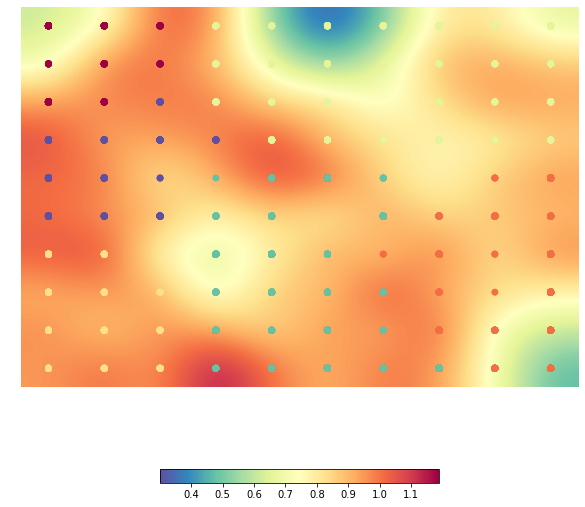

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 10))

#### k=25

In [0]:
from sklearn.cluster import KMeans

K = 25

algorithm = KMeans(n_clusters=K)
som.cluster(algorithm=algorithm)

print("k=" + str(K) + ":\n")
print(som.clusters)
print()
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

k=25:

[[ 9  9  9 23  8  8  8  8  7  7]
 [ 9  9  9 23  8  8  8  8  7  7]
 [19 19  2 20 20 18  8 11 12 12]
 [10 10  2  2 18 18 11 11 11 12]
 [10 10 22  1  1  1  3 11  0  0]
 [22 22 22  3  3  3  3 17  0  0]
 [ 5  5  3  3  3  3 17 17 17 13]
 [21 21  3  3  3 14  3 17 13 13]
 [16 16  4  4  3 14 24  6  6  6]
 [16  4  4 15 15 24 24  6  6  6]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons
[[21. 20. 19.  5. 15. 14. 23. 12. 18. 16. 13. 24.  2.  1. 10.  7.  4. 22.
   0. 17. 11.  9.  6.  8.  3.]
 [ 2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.
   4.  5.  5.  6.  6.  9. 14.]]


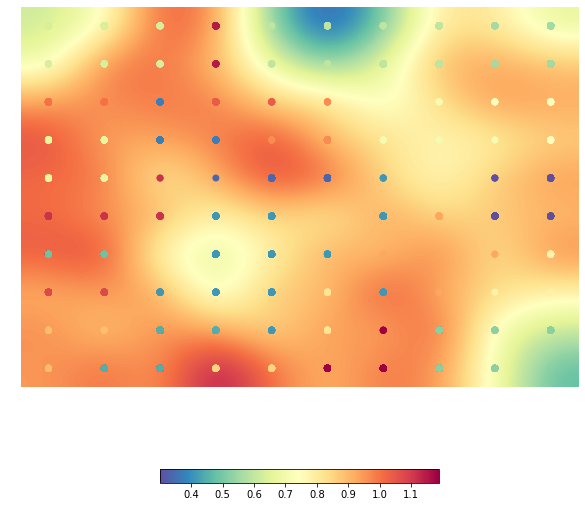

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 10))

Παρατηρούμε ουσιαστικά τρεις περιοχές, οι οποίες χωρίζονται με μία μεγάλη κόκκινη περιόχη. Στην περιοχή αυτή βρίσκονται σημεία που απέχουν μεγάλη απόσταση μεταξύ τους. Αυτό μπορούμε να το ερμηνεύσουμε ως εξής: το dataset αποτελείται από τρία μεγάλα είδη ταινιών ή οικογένειας ειδών ταινιών (πχ action/action-adventure/thriller ή comedy/romantic comedy/romance film), οι οποίες όμως ανήκουν και σε άλλα είδη επικαλυπτόμενα μεταξύ τους (πχ να είναι ταυτόχρονα και drama ή black and white).

### 20x20

#### k=20

In [0]:
from sklearn.cluster import KMeans

K = 20

algorithm = KMeans(n_clusters=K)
som20.cluster(algorithm=algorithm)

print("k=" + str(K) + ":\n")
print(som20.clusters[:,0:16])  # δεν μπορει ολοκληρο προκειμενου να ειναι ευπαρουσιαστο
print()
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

k=20:

[[10 10 10 10 15 15 15 15 15 15 15 15 15 15 15 15]
 [10 10 10 10 15 15 15 15 15 15 15 15 15 15 15 15]
 [10 10 10 10 15 15 15 15 15 15 15 15 15 15  6  6]
 [10 10 10 10 10 15 14 15 15 15 15 15 15  6  6  6]
 [10 10 10 10 10 14 14 14 14 15 15 15 15  6  6  6]
 [10 10 10 10 14 14 14 14 14 14  3  3  3  3  6  6]
 [ 9  9  0 14 14 14 14 14 14 14  3  3  3  3 17 17]
 [ 9  9  9  0  0 14  0  0 14 14 12  3 17 17 17 17]
 [ 9  9  9  0  0  0  0  0 12 12 12 12 17 17 17 17]
 [ 9  9  9  9  0  0  0  0 12 12 12 12 17 17 17 13]
 [ 9  9  9  9  9  9  7  9  9 12 12 12 17 17  1 13]
 [16 16  9  9  9  9  7  7  5  5  5  5  1  1  1  1]
 [16 16 16 16 16  9  9  7  5  5  5  5  1  1  1  1]
 [16 16 16 16  4  4  4  4  5  5  5  5  1  1  1  1]
 [16 16 16  4  4  4  4  4  4  5  5  5  1  1  1  1]
 [16  4  4  4  4  4  4  4  8  2  5  2  1  1  1  2]
 [11 11 11  4  4  4  8  8  8  2  2  2  2  1  2  2]
 [11 11 11 11  8  8  8  8  8  8  7  7  7  7  2  2]
 [11 11 11 11  8  8  8  8  8  7  7  7  7  7  7  2]
 [11 11 11 11  8  8  8  

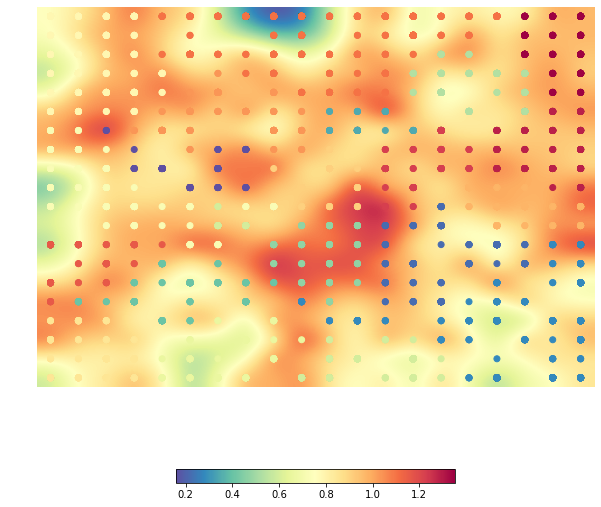

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som20.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 10))

#### k=9

In [0]:
from sklearn.cluster import KMeans

K = 9

algorithm = KMeans(n_clusters=K)
som20.cluster(algorithm=algorithm)

print("k=" + str(K) + ":\n")
print(som20.clusters[:,0:16])  # δεν μπορει ολοκληρο προκειμενου να ειναι ευπαρουσιαστο
print()
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

k=9:

[[6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 5]
 [6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 5]
 [6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 5]
 [6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 5]
 [6 6 6 6 6 8 8 8 7 7 7 7 7 7 7 7]
 [6 6 6 6 8 8 8 7 7 7 7 7 7 7 7 7]
 [0 0 8 8 8 8 8 7 7 7 7 7 7 7 7 7]
 [0 0 0 8 8 8 8 8 7 7 7 7 7 7 2 2]
 [0 0 0 8 8 8 8 8 8 7 7 7 7 7 2 2]
 [0 0 0 0 8 8 8 8 0 0 7 7 7 2 2 2]
 [0 0 0 0 0 0 4 4 0 4 4 4 2 2 2 2]
 [0 0 0 0 0 0 4 4 4 4 4 4 2 2 2 2]
 [0 0 0 0 0 0 0 4 4 4 4 4 4 1 2 2]
 [0 0 0 0 3 3 0 0 4 4 4 4 1 1 1 2]
 [0 0 3 3 3 3 3 0 0 4 4 4 1 1 1 1]
 [3 3 3 3 3 3 3 0 0 4 4 1 1 1 1 1]
 [3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 3 1 4 4 4 1 1 1 1]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 6.  8.  4.  5.  3.  0.  2.  1.  7.]
 [26. 26. 29. 29. 42. 46. 46. 73. 83.]]


In [0]:
som20.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 10))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

Στο μοντέλο αυτό παρατηρούμε πιο πολλές περιοχές, μία αρκετά ξεκάθαρη (μπλε) και οι υπόλοιπες (πράσινες) λιγότερο. Αυτό μπορούμε να πούμε πως συμβαίνει γιατί το grid έχει μεγαλύτερες διαστάσεις αυτή την φορά, με αποτελέσμα να καταφέρνει ο KMeans να διαχωρίζει τις μεγάλες οικογένειες ειδών ταινιών, που είχαμε στο 10x10, σε μικρότερες. Για αυτό τον λογό βλέπουμε τώρα πιο πολλές πράσινες περιοχές. Όσο θα μεγαλώνει το grid τοσο πιο πολλές υποπεριοχές θα συναντάμε, καθώς θα βλέπουμε με μεγαλύτερη ανάλυση την κάθε οικογένεια. Ωστόσο, κάτι τέτοιο, πέρα από αρκετά χρονοβόρο, δεν εγγυάται πάντα καλύτερη επίδοση στη συσταδοποίηση.

 Όπως θα δούμε στην συνέχεια, η συσταδοποίηση εξαρτάται σε μεγάλο βαθμό από την τιμή του k του KMeans για κάθε τοπολογία του grid, με αποτελέσμα ακόμα και σε μικρά πλέγματα να βλέπουμε ικανοποιητικά αποτελέσματα.


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.   

In [0]:
def print_cluster_neurons_movies_report(cluster_id, som, size):
    '''
        clustr_id:   int
        som:         Somoclu instance 
    '''
    
    # Movies that belong to cluster_id
    a = np.sum(np.reshape([som.clusters == cluster_id], (1,size**2)), axis=0)
    a = np.reshape(a, (size,size)).transpose()
    where = np.where(a==1)
    cluster_bmus = np.squeeze(np.dstack((where[0], where[1])))   # possible bmus
    ids = []
    for c_bmu in cluster_bmus:
        for i,bmu in enumerate(som.bmus):
            if np.array_equal(c_bmu, bmu):
                ids.append(i)    
    
    ids = np.array(ids)
    cluster_catbins = new_catbins[ids]

    # Categories indexes and their names in descending order frequency
    cat_indexes = np.argsort(np.sum(cluster_catbins, axis=0))[::-1]
    cat_sorted_names = [dict_idx_cat[i] for i in cat_indexes]

    # Categories frequencies in descending order
    cat_freq = sorted(np.sum(cluster_catbins, axis=0))[::-1]

    # Stats
    cluster_stats_result = list(zip(cat_sorted_names, cat_freq))    
    print(cluster_stats_result[0:5])   # print stats for first five top categories

Λαμβάνουμε υπόψιν πως μικρός αριθμός k στον ΚΜeans δεν θα σέβεται τα όρια, ενώ μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά. Παρακάτω κάνουμε χρήση δυο από τα clustering που είδαμε παραπάνω. Για το 10x10 χρησιμοποιούμε $k=6$, ενώ για το 20x20, $k=9$, τιμές που είδαμε ποιοτικά πως ταιριάζουν στα παραπάνω U-Matrix των μοντέλων SOM. Σημειώνουμε πως μελετήσαμε και για μεγαλύτερες τιμές του k τις προαναφερθείσες εκπαιδεύσεις, αλλά παρόλα αυτά οι καλύτερες ποιοτικά προέκυψαν για τις παρακάτω τιμές του k.

### 10x10, k = 6

In [0]:
%time print_cluster_neurons_movies_report(0, som, size=10)

[('"Thriller"', 420.0), ('"Drama"', 263.0), ('"Crime Fiction"', 191.0), ('"Crime Thriller"', 154.0), ('"Mystery"', 151.0)]
CPU times: user 332 ms, sys: 16 ms, total: 348 ms
Wall time: 336 ms


In [0]:
%time print_cluster_neurons_movies_report(1, som, size=10)

[('"Comedy"', 912.0), ('"Drama"', 293.0), ('"Romance Film"', 271.0), ('"Romantic comedy"', 195.0), ('"Black-and-white"', 130.0)]
CPU times: user 531 ms, sys: 39.9 ms, total: 571 ms
Wall time: 533 ms


In [0]:
%time print_cluster_neurons_movies_report(2, som, size=10)

[('"Horror"', 444.0), ('"Thriller"', 134.0), ('"Slasher"', 80.0), ('"Science Fiction"', 79.0), ('"Supernatural"', 62.0)]
CPU times: user 257 ms, sys: 7.94 ms, total: 264 ms
Wall time: 248 ms


In [0]:
%time print_cluster_neurons_movies_report(3, som, size=10)

[('"Drama"', 1553.0), ('"Romance Film"', 361.0), ('"World cinema"', 346.0), ('"Romantic drama"', 216.0), ('"Indie"', 142.0)]
CPU times: user 787 ms, sys: 55.7 ms, total: 842 ms
Wall time: 777 ms


In [0]:
%time print_cluster_neurons_movies_report(4, som, size=10)

[('"Action"', 490.0), ('"Action/Adventure"', 308.0), ('"Thriller"', 197.0), ('"Adventure"', 149.0), ('"Drama"', 125.0)]
CPU times: user 473 ms, sys: 116 ms, total: 589 ms
Wall time: 412 ms


In [0]:
%time print_cluster_neurons_movies_report(5, som, size=10)

[('"Short Film"', 255.0), ('"Animation"', 244.0), ('"Family Film"', 196.0), ('"Comedy film"', 138.0), ('"Adventure"', 132.0)]
CPU times: user 674 ms, sys: 24 ms, total: 698 ms
Wall time: 658 ms


Το παραπάνω μοντέλο συσταδοποιεί τις ταινίες σε 6 θεματικές κατηγορίες: thriller/crime, comedy/romantic, horror, drama, action/adventure, short/animation/family. Παρατηρούμε πως οι παραπάνω κατηγορίες είναι αρκετά αντιπροσωπευτικές του dataset μας, καθώς αποτελούν τις 6 μεγαλύτερες κατηγορίες ταινιών που είχαμε στην διάθεσή μας. Έτσι, καταλαβαίνουμε πως το μοντέλο μας λειτουργεί αρκέτα αποτελεσματικά, με αποτελέσμα ακόμα και για μικρές διαστάσεις του grid, σε σχέση με τα data points που είχαμε, να είμαστε σε θέση να κατηγοριοποιήσουμε τις ταινίες με ικανοποιητικό τρόπο.

### 20x20, k=9

In [0]:
%time print_cluster_neurons_movies_report(0, som20, size=20)

[('"Action"', 415.0), ('"Action/Adventure"', 310.0), ('"Thriller"', 190.0), ('"Adventure"', 152.0), ('"Drama"', 121.0)]
CPU times: user 1.21 s, sys: 35.8 ms, total: 1.25 s
Wall time: 1.23 s


In [0]:
%time print_cluster_neurons_movies_report(1, som20, size=20)

[('"Drama"', 1158.0), ('"World cinema"', 178.0), ('"Crime Fiction"', 103.0), ('"Black-and-white"', 91.0), ('"War film"', 90.0)]
CPU times: user 2.23 s, sys: 36 ms, total: 2.27 s
Wall time: 2.24 s


In [0]:
%time print_cluster_neurons_movies_report(2, som20, size=20)

[('"Comedy"', 625.0), ('"Drama"', 144.0), ('"Romance Film"', 133.0), ('"Romantic comedy"', 109.0), ('"Indie"', 84.0)]
CPU times: user 1.35 s, sys: 23.9 ms, total: 1.37 s
Wall time: 1.36 s


In [0]:
%time print_cluster_neurons_movies_report(3, som20, size=20)

[('"Drama"', 464.0), ('"Romance Film"', 463.0), ('"Romantic drama"', 252.0), ('"Comedy"', 127.0), ('"World cinema"', 127.0)]
CPU times: user 926 ms, sys: 28 ms, total: 954 ms
Wall time: 928 ms


In [0]:
%time print_cluster_neurons_movies_report(4, som20, size=20)

[('"Family Film"', 264.0), ('"Animation"', 166.0), ('"Comedy"', 152.0), ('"Short Film"', 99.0), ('"Adventure"', 80.0)]
CPU times: user 867 ms, sys: 32 ms, total: 899 ms
Wall time: 865 ms


In [0]:
%time print_cluster_neurons_movies_report(5, som20, size=20)

[('"Black-and-white"', 211.0), ('"Comedy"', 112.0), ('"Silent film"', 79.0), ('"Short Film"', 63.0), ('"Indie"', 54.0)]
CPU times: user 687 ms, sys: 8.07 ms, total: 695 ms
Wall time: 686 ms


In [0]:
%time print_cluster_neurons_movies_report(6, som20, size=20)

[('"Thriller"', 367.0), ('"Drama"', 291.0), ('"Crime Fiction"', 212.0), ('"Crime Thriller"', 162.0), ('"Mystery"', 151.0)]
CPU times: user 850 ms, sys: 4.13 ms, total: 854 ms
Wall time: 855 ms


In [0]:
%time print_cluster_neurons_movies_report(7, som20, size=20)

[('"Horror"', 434.0), ('"Thriller"', 134.0), ('"Science Fiction"', 79.0), ('"Slasher"', 79.0), ('"Supernatural"', 65.0)]
CPU times: user 764 ms, sys: 12 ms, total: 776 ms
Wall time: 777 ms


In [0]:
%time print_cluster_neurons_movies_report(8, som20, size=20)

[('"Short Film"', 143.0), ('"Documentary"', 123.0), ('"Comedy film"', 117.0), ('"Animation"', 96.0), ('"Action"', 92.0)]
CPU times: user 2.18 s, sys: 52 ms, total: 2.23 s
Wall time: 2.21 s


Το παραπάνω μοντέλο συσταδοποιεί τις ταινίες σε 9 θεματικές κατηγορίες: Action, Drama, Comedy, Drama/Romantic, Family, Black and White, Thriller/Crime, Horror, Short/Documentary. Βλέπουμε, δηλαδή, να περιέχει συστάδες με κάποιες από τις υποοικογένειες του προηγούμενου μοντέλου είτε από ταινίες που ανήκαν σε διαφορετικές οικογένειες αυτού. Επίσης, αξίζει να τονιστεί πως στις μεγάλες οικογένειες ταινιών, drama, comedy, horror, action οι αντίστοιχες συστάδες περιέχουν αυτές τις κατηγορίες σε πολύ μεγάλες συχνότητες. Αυτό δείχνει πως το μοντέλο μας έχει χτιστεί γύρω από αυτές τις κατηγορίες και οι υπόλοιπες συστάδες περιέχουν σε σχετικά μεγάλες συχνότητες (μεγαλύτερες στο cluster που ανήκουν) τις πιο διακριτές υποκατηγορίες τους (thriller, black and white, documentary, short film, family, romantic). Έτσι, επιτυγχάνεται αποτελεσματικό clustering των ταινιών ανάλογα με το περιεχόμενο τους στις αντίστοιχες κατηγορίες τους.

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

### Περεταίρω μελέτη του μοντέλου 20x20 με k=9

In [0]:
som20.view_umatrix(bestmatches=True, colorbar=True, figsize=(20, 20))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
print("20x20, k=9")
print()
print(som20.clusters[:])  
print()
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

20x20, k=9

[[6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5]
 [6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5]
 [6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5]
 [6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5]
 [6 6 6 6 6 8 8 8 7 7 7 7 7 7 7 7 5 5 5 5]
 [6 6 6 6 8 8 8 7 7 7 7 7 7 7 7 7 5 5 5 5]
 [0 0 8 8 8 8 8 7 7 7 7 7 7 7 7 7 2 5 2 2]
 [0 0 0 8 8 8 8 8 7 7 7 7 7 7 2 2 2 2 2 2]
 [0 0 0 8 8 8 8 8 8 7 7 7 7 7 2 2 2 2 2 2]
 [0 0 0 0 8 8 8 8 0 0 7 7 7 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 4 4 0 4 4 4 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 4 4 4 4 4 4 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 4 4 4 4 4 4 1 2 2 2 2 1 1]
 [0 0 0 0 3 3 0 0 4 4 4 4 1 1 1 2 2 2 2 1]
 [0 0 3 3 3 3 3 0 0 4 4 4 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 0 0 4 4 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 3 1 4 4 4 1 1 1 1 1 1 1 1]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 6.  8.  4.  5.  3.  0.  2.  1.  7.]
 [26. 2

Από τα παραπάνω αποτελέσματα συμπεραίνουμε ότι το cluster με τους περισσότερους νευρώνες (7) είναι αυτό που τα δεδομένα του έχουν την μεγαλύτερη πυκνότητα πιθανότητας στο χώρο και είναι κυρίως στην πιο μπλε περιοχή, και αυτά αποτελούν τις ταινίες horror, επειδή αυτές είναι συνήθως και thriller ή slasher, με αποτέλεσμα να έχουν πολλές ομοιότητες μεταξύ τους. Ακολουθούν τα clusters που αντιστοιχίζονται στις πιο πράσινες περιοχές (0, 1) και σε μια κόκκινη (2). Αυτές είναι οι υπόλοιπες μεγάλες οικογένειες action, comedy, drama που αναφέραμε προηγουμένως. Και από εκεί και πέρα, οι υπόλοιπες κόκκινες περιοχές που αντιστοιχίζονται στα υπόλοιπα clusters, και είναι είτε οι υποοικογένειες των παραπάνω (πχ drama-romantic) είτε ενδιάμεσες κατηγορίες ταινιών που αποτελούν και μίξη μεγάλων κατηγοριών (πχ comedy-horror), και περιέχουν κοντινά πρότυπα, είτε μικρές νέες οικογένειες (πχ black and white), που περιέχουν και απομακρυσμένα πρότυπα.  

Αξίζει να σημειωθεί ότι το cluster (2) που βρίσκεται σε κόκκινη περιοχή αποτελείται από πολλούς νευρώνες, επειδή περιέχουν τα comedy, και αυτά ως προς το περιεχόμενό τους μπορεί να διαφέρουν αρκετά (romantic, drama, action comedies). Επιπλέον, η πιο κόκκινη περιοχή, cluster (4), ανήκει στις family, animation, comedy, και όπως και στο cluster (2), περιμέναμε ακόμη μεγαλύτερη απόσταση μεταξύ τους, καθώς ποιοτικά και σημασιολογικά μπορεί να φαίνεται λογικό να είναι κοντά, ωστόσο δεν αποτελούν μακρινά πρότυπα μεταξύ τους.   

Ακόμη, βλέπουμε το εξής ενδιαφέρον ότι το comedy (2) συνορεύει με τις υποοικογένειές του (4, 5), το (7) με το (6) που αποτελούν σε μεγάλο βαθμό και τα δυο κατηγορίες thriller, ενώ το drama (1) με την υποοικογένειά του (3). Με χρήση μεγαλύτερου grid και με αυξημένη τιμή του k του KMeans, ενδέχεται να εμφανιζόντουσαν και άλλες υποοικογένειας που θα γειτνίαζαν με τις αντίστοιχες μεγάλες οικογένειες, ωστόσο με τον κίνδυνο οι μεγάλες οικογένειες να διασπαζόντουσαν περισσότερο σε μικρότερες και να εμφανιζόντουσαν αρκετές επικαλύψεις στις κατηγοριές που θα περιείχαν τα διαφορετικά clusters.

Το μόνο που τοπολογικά διαφέρει κάπως σημασιολογικά είναι πως τα clusters (8) και (5) θα μπορούσαν να ήταν κάπως πιο κοντά μεταξύ τους. Αυτό ενδεχομένως οφείλεται στο ότι στο ένα έχουμε κυρίως short films πιο κοντά στο documentary ενώ στο άλλο short films πιο κοντά στο comedy και στο black and white, με αποτέλεσμα η τελευταία κατηγορία να αποτελείται κυρίως από πιο απομακρυσμένα πρότυπα.   

Ωστόσο, είναι σίγουρο πως τοποθέτηση σε δυο διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.